In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# perrform pca over csv data
def pca_over_csv(data):
    pca = PCA(n_components=20)
    pca.fit(data)
    return pca.transform(data), pca



In [3]:
# load csv data
def load_csv_data(file_path):
    data = pd.read_csv(file_path, header=None).values
    return data

path = '../data/train_pre_pca.csv'
data = load_csv_data(path)
data, pca = pca_over_csv(data)
print(data.shape)



(64800, 20)


In [4]:
#transform validation data using pca
path = '../data/val_pre_pca.csv'
val_data = load_csv_data(path)
val_data = pca.transform(val_data)
print(val_data.shape)

(7200, 20)


In [5]:
#transform train data using pca
path = '../data/train_pre_pca.csv'
data = load_csv_data(path)
train_data, pca = pca_over_csv(data)
train_data = train_data.astype(np.float32)

path = '../data/xgb_pred_train.csv'
merge_train = load_csv_data(path).astype(np.float32)
print(merge_train.shape)

path = '../data/xgb_pred_val.csv'
merge_val = load_csv_data(path).astype(np.float32)

path = '../data/val_pre_pca.csv'
val_data = load_csv_data(path)
val_data = pca.transform(val_data).astype(np.float32)

path = '../data/y_train.csv'
y_train = load_csv_data(path).astype(np.float32)

path = '../data/y_val.csv'
y_val = load_csv_data(path).astype(np.float32)


(64800, 1)


In [6]:
#Ttransform data to torch tensors
input_conv_train = torch.from_numpy(train_data.astype(np.float32)).unsqueeze(1)
input_merge_train = torch.from_numpy(merge_train.astype(np.float32))
labels_train = torch.from_numpy(y_train.astype(np.float32))

input_conv_val = torch.from_numpy(val_data.astype(np.float32)).unsqueeze(1)
input_merge_val = torch.from_numpy(merge_val.astype(np.float32))
labels_val = torch.from_numpy(y_val.astype(np.float32))

print(input_conv_train.shape)
print(input_merge_train.shape)
print(labels_train.shape)

print(input_conv_val.shape)
print(input_merge_val.shape)
print(labels_val.shape)

torch.Size([64800, 1, 20])
torch.Size([64800, 1])
torch.Size([64800, 1])
torch.Size([7200, 1, 20])
torch.Size([7200, 1])
torch.Size([7200, 1])


In [7]:
# Create DataLoader objects
train_dataset = TensorDataset(input_conv_train, input_merge_train, labels_train)
val_dataset = TensorDataset(input_conv_val, input_merge_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/Users/brunocr/opt/anaconda3/envs/vision/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/20, Train Loss: 1.6110, Validation Loss: 1.1439
Epoch 2/20, Train Loss: 0.7887, Validation Loss: 1.1439
Epoch 3/20, Train Loss: 0.7841, Validation Loss: 1.1459
Epoch 4/20, Train Loss: 0.7831, Validation Loss: 1.1519
Epoch 5/20, Train Loss: 0.7803, Validation Loss: 1.1467
Epoch 6/20, Train Loss: 0.7808, Validation Loss: 1.1459
Epoch 7/20, Train Loss: 0.7795, Validation Loss: 1.1485
Epoch 8/20, Train Loss: 0.7788, Validation Loss: 1.1483
Epoch 9/20, Train Loss: 0.7783, Validation Loss: 1.1453
Epoch 10/20, Train Loss: 0.7783, Validation Loss: 1.1466
Epoch 11/20, Train Loss: 0.7763, Validation Loss: 1.1441
Epoch 12/20, Train Loss: 0.7769, Validation Loss: 1.1483
Epoch 13/20, Train Loss: 0.7751, Validation Loss: 1.1451
Epoch 14/20, Train Loss: 0.7754, Validation Loss: 1.1480
Epoch 15/20, Train Loss: 0.7757, Validation Loss: 1.1505
Epoch 16/20, Train Loss: 0.7753, Validation Loss: 1.1435
Epoch 17/20, Train Loss: 0.7753, Validation Loss: 1.1452
Epoch 18/20, Train Loss: 0.7756, Validat

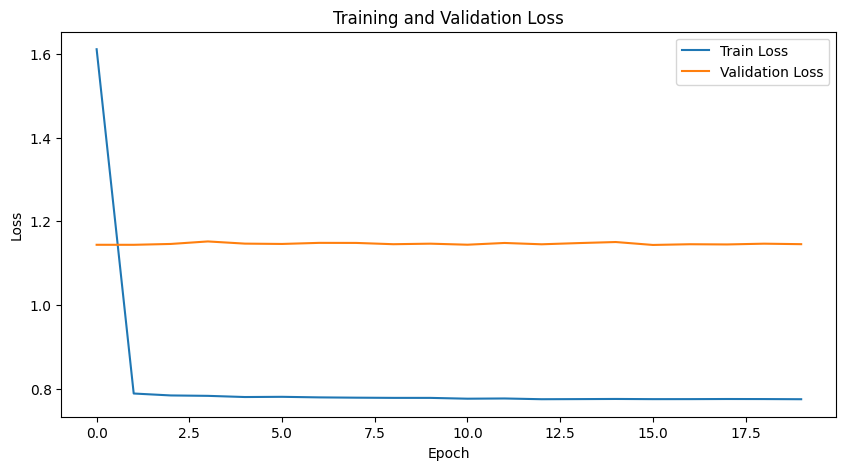

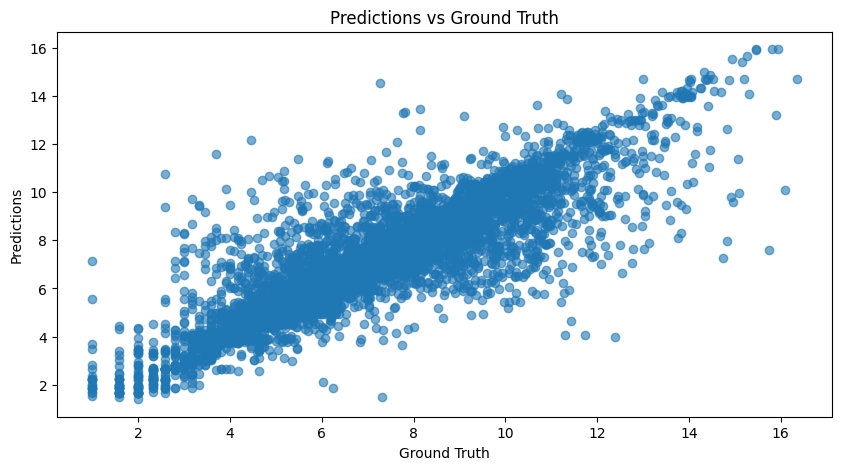

In [8]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)

        self.dropout = nn.Dropout(0.75)  # 75% dropout

        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc1 = nn.Linear(128 + 1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x1, x2):

        # Convolutional layers
        x1 = self.relu(self.bn1(self.conv1(x1)))
        x1 = self.relu(self.bn2(self.conv2(x1)))
        x1 = self.relu(self.bn3(self.conv3(x1)))

        x1 = torch.mean(x1, dim=-1)  # average pooling

        x1 = self.dropout(x1)

        # Merge x1 with xgb prediction
        x = torch.cat((x1, x2), dim=1) 

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 

        return x

model = CustomNet()
model = model.float() 

# Define the loss function
criterion = nn.MSELoss()

# adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


# Training and val loop
num_epochs = 20
train_losses = []
val_losses = []

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x1, x2, y in train_loader:
        optimizer.zero_grad()
        predictions = model(x1, x2)
        loss = torch.sqrt(criterion(predictions, y))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    scheduler.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x1, x2, y in val_loader:
            predictions = model(x1, x2)
            loss =torch.sqrt(criterion(predictions, y))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# predictions vs ground truth
model.eval()
with torch.no_grad():
    val_preds = []
    val_truth = []
    for x1, x2, y in val_loader:
        preds = model(x1, x2).squeeze().numpy()
        val_preds.extend(preds)
        val_truth.extend(y.squeeze().numpy())

plt.figure(figsize=(10, 5))
plt.scatter(val_truth, val_preds, alpha=0.6)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth')
plt.show()


In [9]:
path = '../data/xgb_pred_test.csv'
merge_test = load_csv_data(path).astype(np.float32)
print(merge_test.shape)


path = '../data/test_pre_pca.csv'
test_data = load_csv_data(path)
test_data = pca.transform(test_data).astype(np.float32)

path = '../data/y_test.csv'
y_test = load_csv_data(path).astype(np.float32)

input_conv_test= torch.from_numpy(test_data.astype(np.float32)).unsqueeze(1)
input_merge_test = torch.from_numpy(merge_test.astype(np.float32))
labels_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(input_conv_test, input_merge_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



(8000, 1)


1.1762963924349212


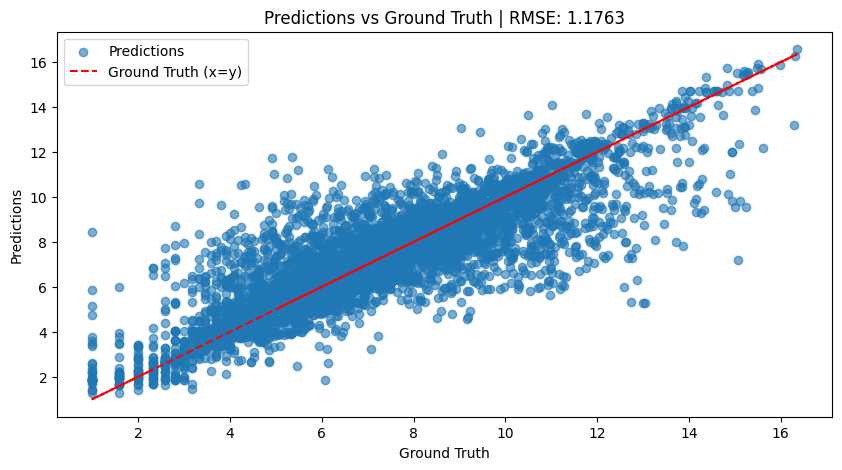

In [10]:
model.eval()
with torch.no_grad():
    val_preds = []
    val_truth = []
    for x1, x2, y in test_loader:
        preds = model(x1, x2).squeeze().numpy()
        val_preds.extend(preds)
        val_truth.extend(y.squeeze().numpy())

#cal;culate the rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(val_truth, val_preds))
print(rmse)

plt.figure(figsize=(10, 5))
plt.scatter(val_truth, val_preds, alpha=0.6, label='Predictions')
plt.plot(val_truth, val_truth, color='red', linestyle='--', label='Ground Truth (x=y)')  # Ground truth line
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth | RMSE: {:.4f}'.format(rmse))
plt.legend() 
plt.show()

/var/folders/7f/w8t6fsgd78gfxd_lgh6918b00000gn/T/ipykernel_8375/830302271.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Media: {mean_error:.2f}\Varianza: {var_error:.2f}', loc='upper right')


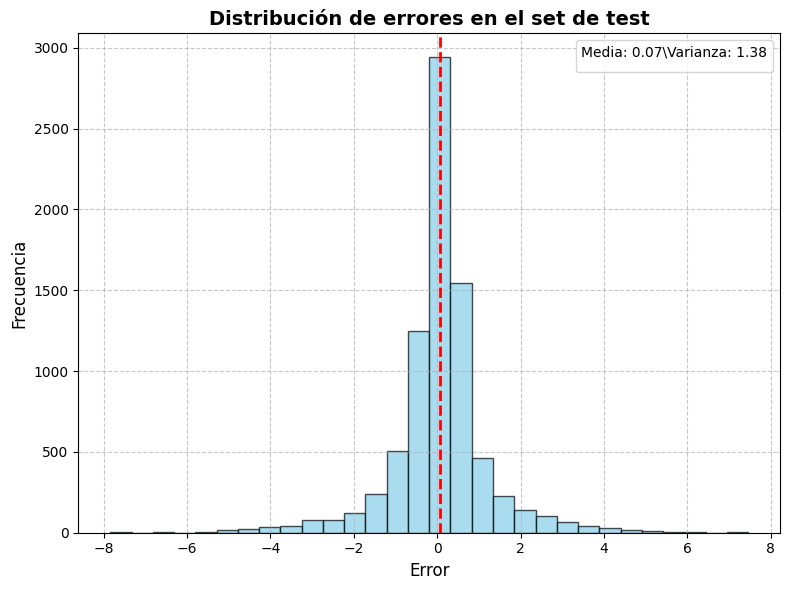

In [11]:
import numpy as np
def plot_error_distribution(y_pred_test, y_test):

    errors = []
    for pred, true in zip(y_pred_test, y_test):
        errors.append(pred - true)

    mean_error = np.mean(errors)
    std_error = np.std(errors)
    var_error = np.var(errors)

    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2)

    plt.title('Distribución de errores en el set de test', fontsize=14, weight='bold')
    plt.xlabel('Error', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    plt.legend(title=f'Media: {mean_error:.2f}\Varianza: {var_error:.2f}', loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('white')

    plt.tight_layout()
    plt.show()

plot_error_distribution(val_preds, val_truth)